In [1]:
import torch
from torchvision import models
import torch.nn as nn

# Load DeepLabV3 with pretrained weights
model = models.segmentation.deeplabv3_resnet101(pretrained=True)

# Modify final classifier for 2 output classes (e.g., Bubble & Non-Bubble)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)

# Optional: freeze backbone if you want to train only the decoder
for param in model.backbone.parameters():
    param.requires_grad = False

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set to eval mode (for inference)
model.eval()


c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\Soham/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:08<00:00, 30.4MB/s] 


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

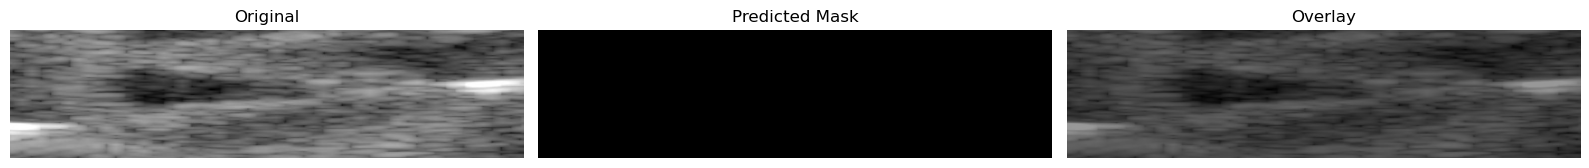

In [2]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load image
image_path = "Data/US_Test_2023April7/t3US94_738983_4.jpg"
image = Image.open(image_path).convert('RGB')
orig_size = image.size

# Preprocess
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

input_tensor = preprocess(image).unsqueeze(0).to(device)

# Inference
with torch.no_grad():
    output = model(input_tensor)['out']
    preds = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

# Resize mask to original size
mask_resized = cv2.resize(preds.astype(np.uint8), orig_size, interpolation=cv2.INTER_NEAREST)

# Overlay with original image
image_np = np.array(image)
color_mask = np.zeros_like(image_np)
color_mask[mask_resized == 1] = [255, 0, 0]  # Red for bubbles

overlay = cv2.addWeighted(image_np, 0.6, color_mask, 0.4, 0)

# Plot
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_resized, cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
# STEP 0: Imports
import os
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import matplotlib.pyplot as plt


# STEP 1: Custom Dataset for Bubble Images
class BubbleDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform_img=None, transform_label=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform_img = transform_img
        self.transform_label = transform_label

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        label = Image.open(self.label_paths[idx])

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_label:
            label = self.transform_label(label)

        return image, label


# STEP 2: Parsing and Splitting Data Based on Dataset Number
all_images = sorted(glob.glob('Data/US_2/*.jpg'))
all_labels = sorted(glob.glob('Data/Labels_2/*.png'))

# Extract dataset number (last digit before .jpg)
def extract_dataset_number(path):
    return int(path.split('_')[-1].split('.')[0])

groups = [extract_dataset_number(p) for p in all_images]

splitter = GroupShuffleSplit(n_splits=1, test_size=1/6, random_state=42)
train_idx, val_idx = next(splitter.split(all_images, groups=groups))

train_images = [all_images[i] for i in train_idx]
train_labels = [all_labels[i] for i in train_idx]
val_images = [all_images[i] for i in val_idx]
val_labels = [all_labels[i] for i in val_idx]

print("Sample mapping:")
for img, lbl in zip(train_images[:3], train_labels[:3]):
    print(f"{img}  -->  {lbl}")


# STEP 3: Transforms
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


# STEP 4: DataLoaders
train_dataset = BubbleDataset(train_images, train_labels, img_transform, label_transform)
val_dataset = BubbleDataset(val_images, val_labels, img_transform, label_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


Sample mapping:
Data/US_2\t3US100_738966_2.jpg  -->  Data/Labels_2\t3Label100_738966_2.png
Data/US_2\t3US100_738966_3.jpg  -->  Data/Labels_2\t3Label100_738966_3.png
Data/US_2\t3US100_738966_4.jpg  -->  Data/Labels_2\t3Label100_738966_4.png


In [4]:
# STEP 5: Model Setup
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# STEP 6: Training Loop (simplified)
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.cuda(), masks.cuda()
        optimizer.zero_grad()
        output = model(imgs)['out']
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for imgs, masks in val_loader:
            imgs, masks = imgs.cuda(), masks.cuda()
            output = model(imgs)['out']
            loss = criterion(output, masks)
            val_loss += loss.item()
        print(f"Epoch {epoch+1}, Val Loss: {val_loss/len(val_loader):.4f}")



c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Soham\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
model.eval()
test_img_path = 'Data/US_Test_2023April7/t3US1_738983_1.jpg'
test_label_path = 'Data/Labels_Test_2023April7/t3Label1_738983_1.png'

test_img = Image.open(test_img_path).convert('L')
test_tensor = img_transform(test_img).unsqueeze(0).cuda()

with torch.no_grad():
    output = model(test_tensor)['out']
    pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# STEP 8: Visualization
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(test_img, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(pred_mask, cmap='gray')
axs[1].set_title('Predicted Mask')
axs[2].imshow(test_img, cmap='gray')
axs[2].imshow(pred_mask, alpha=0.4, cmap='jet')
axs[2].set_title('Overlay')
plt.show()